# My(!) very own neural network

In this notebook we're going to build a neural network using naught but pure numpy and steel nerves. It's going to be fun, I promise!

For conclusions and some additional tests scroll until the end.

Disclaimer: This report is based on honor track assignment notebook of Introduction to deep learning course (https://www.coursera.org/learn/intro-to-deep-learning) as part of the Advanced Machine Learning Specialization on Coursera

Hello all!

- The layer class is defined, as well as the ReLu and dense classes.
- The weights Xavier initialization is performed using a normal distribution with mean 0 and standard deviation $\sqrt(\frac{2}{n_{in}})$, where $n_{in}$ is the number of neurons of the layer as suggested by Kaiming He, Xiangyu Zhang, Shaoqing Ren and Jian Sun in https://arxiv.org/abs/1502.01852.
- The loss function is defined from the softmax function.
- A network with 5 layers is trained under two different conditions:
    * using xavier initialization
    * using normal initialization
- A network with 3 layers is trained under two different conditions:
    * using xavier initialization
    * using normal initialization

It is found that as many layers are added, more critical could be the choice of the weights initialization. Therefore, the right choice for this parameter should be carefully studied.

In [1]:
#https://github.com/hse-aml/intro-to-dl
import sys
sys.path.append("..")
import tqdm_utils
import download_utils

In [2]:
# use the preloaded keras datasets and models
download_utils.link_all_keras_resources()

In [3]:
from __future__ import print_function
import numpy as np
np.random.seed(42)

Here goes our main class

### Layer class


In [4]:
class Layer:
    """
    A building block. Each layer is capable of performing two things:
    
    - Process input to get output:           output = layer.forward(input)
    
    - Propagate gradients through itself:    grad_input = layer.backward(input, grad_output)
    
    Some layers also have learnable parameters which they update during layer.backward.
    """
    def __init__(self):
        """Here you can initialize layer parameters (if any) and auxiliary stuff."""
        # A dummy layer does nothing
        pass


### Nonlinearity layer

It simply applies a nonlinearity to each element of your network.

In [5]:
class ReLU(Layer):
    def __init__(self):
        """ReLU layer simply applies elementwise rectified linear unit to all inputs"""
        pass
    
    def forward(self, input):
        """Apply elementwise ReLU to [batch, input_units] matrix"""
        return np.maximum(0, input) # f(x) = max(0, x)
    
    def backward(self, input, grad_output):
        """Compute gradient of loss w.r.t. ReLU input"""
        relu_grad = input > 0
        return grad_output*relu_grad        

### Dense layer


* X is an object-feature matrix of shape [batch_size, num_features],
* W is a weight matrix [num_features, num_outputs] 
* and b is a vector of num_outputs biases.

Both W and b are initialized during layer creation and updated each time backward is called.
Xavier initialization makes sure the weights are ‘just right’, keeping the signal in a reasonable range of values through many layers.

In [6]:
class Dense(Layer):
    def __init__(self, input_units, output_units, learning_rate=0.1, 
                 inicialization = 'normal'):
        """
        A dense layer is a layer which performs a learned affine transformation:
        f(x) = <W*x> + b
        """
        self.learning_rate = learning_rate
        self.inicialization = inicialization
        
        # initialize weights with small random numbers. We use normal initialization, 
        if inicialization == 'normal':
            self.weights = np.random.randn(input_units, output_units)*0.01
        
        # Trying with Xavier inicialization 
        if inicialization == 'xavier':
            mu, sigma = 0, (2/input_units)**(1/2) # We are using ReLu activation function 
            self.weights = np.random.normal(mu, sigma, (input_units, output_units))
        
        self.biases = np.zeros(output_units)
        
    def forward(self,input):
        """
        Perform an affine transformation:
        f(x) = <W*x> + b
        
        input shape: [batch, input_units]
        output shape: [batch, output units]
        """
        return np.dot(input, self.weights) + self.biases # [batch, input_features].[input_features, outputs]
    
    def backward(self,input,grad_output):
        
        # compute d f / d x = d f / d dense * d dense / d x
        # where d dense/ d x = weights transposed
        grad_input = np.dot(grad_output, np.transpose(self.weights))
        
        # compute gradient w.r.t. weights and biases
        grad_weights = np.dot(np.transpose(input), grad_output)
        grad_biases = np.sum(grad_output, axis = 0) #\Sum_k d f/d dense * 1
        
        assert grad_weights.shape == self.weights.shape and grad_biases.shape == self.biases.shape
        # Here we perform a stochastic gradient descent step. 
        # Later on, you can try replacing that with something better.
        self.weights = self.weights - self.learning_rate * grad_weights
        self.biases = self.biases - self.learning_rate * grad_biases
        
        return grad_input

### The loss function

Since we want to predict probabilities, it would be logical for us to define softmax nonlinearity on top of our network and compute loss given predicted probabilities. However, there is a better way to do so.

If you write down the expression for crossentropy as a function of softmax logits (a), you'll see:

$$ loss = - log \space {e^{a_{correct}} \over {\underset i \sum e^{a_i} } } $$

If you take a closer look, ya'll see that it can be rewritten as:

$$ loss = - a_{correct} + log {\underset i \sum e^{a_i} } $$

It's called Log-softmax and it's better than naive log(softmax(a)) in all aspects:
* Better numerical stability
* Easier to get derivative right
* Marginally faster to compute

So why not just use log-softmax throughout our computation and never actually bother to estimate probabilities.


In [7]:
def softmax_crossentropy_with_logits(logits,reference_answers):
    """Compute crossentropy from logits[batch,n_classes] and ids of correct answers"""
    logits_for_answers = logits[np.arange(len(logits)),reference_answers]
    
    xentropy = - logits_for_answers + np.log(np.sum(np.exp(logits),axis=-1))
    
    return xentropy

def grad_softmax_crossentropy_with_logits(logits,reference_answers):
    """Compute crossentropy gradient from logits[batch,n_classes] and ids of correct answers"""
    ones_for_answers = np.zeros_like(logits)
    ones_for_answers[np.arange(len(logits)),reference_answers] = 1
    
    softmax = np.exp(logits) / np.exp(logits).sum(axis=-1,keepdims=True)
    
    return (- ones_for_answers + softmax) / logits.shape[0]

### Full network

Now let's combine what we've just built into a working neural network. 

In [8]:
def forward(network, X):
    """
    Compute activations of all network layers by applying them sequentially.
    Return a list of activations for each layer. 
    Make sure last activation corresponds to network logits.
    """
    activations = []
    input = X

    for layer in network:
        activations.append(layer.forward(input)) 
        input = activations[-1]
        
    assert len(activations) == len(network)
    return activations

def predict(network,X):
    """
    Compute network predictions.
    """
    logits = forward(network,X)[-1]
    return logits.argmax(axis=-1)

def train(network,X,y):
    """
    Train your network on a given batch of X and y.
    You first need to run forward to get all layer activations.
    Then you can run layer.backward going from last to first layer.
    
    After you called backward for all layers, all Dense layers have already made one gradient step.
    """
    
    # Get the layer activations
    layer_activations = forward(network,X)
    layer_inputs = [X]+layer_activations  #layer_input[i] is an input for network[i]
    logits = layer_activations[-1]
    
    # Compute the loss and the initial gradient
    loss = softmax_crossentropy_with_logits(logits,y)
    loss_grad = grad_softmax_crossentropy_with_logits(logits,y)
    
    for i in range(len(network)-1, -1, -1):
        loss_grad = network[i].backward(layer_inputs[i], loss_grad)
        
    return np.mean(loss)

### Let's load our database of handwritten digits

Using TensorFlow backend.


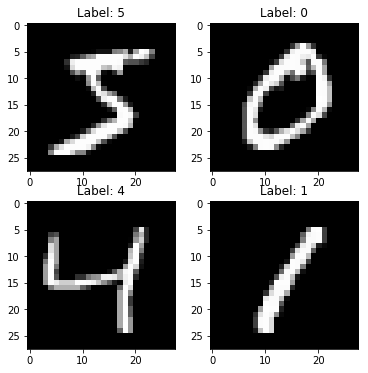

In [9]:
import matplotlib.pyplot as plt
%matplotlib inline

from preprocessed_mnist import load_dataset
X_train, y_train, X_val, y_val, X_test, y_test = load_dataset(flatten=True)

plt.figure(figsize=[6,6])
for i in range(4):
    plt.subplot(2,2,i+1)
    plt.title("Label: %i"%y_train[i])
    plt.imshow(X_train[i].reshape([28,28]),cmap='gray');

### Training loop

As usual, we split data into minibatches, feed each such minibatch into the network and update weights.

In [10]:
def iterate_minibatches(inputs, targets, batchsize, shuffle=False):
    assert len(inputs) == len(targets)
    if shuffle:
        indices = np.random.permutation(len(inputs))
    for start_idx in tqdm_utils.tqdm_notebook_failsafe(range(0, len(inputs) - batchsize + 1, batchsize)):
        if shuffle:
            excerpt = indices[start_idx:start_idx + batchsize]
        else:
            excerpt = slice(start_idx, start_idx + batchsize)
        yield inputs[excerpt], targets[excerpt]

# XAVIER INITIALIZATION

We'll define network as a list of layers, each applied on top of previous one. In this setting, computing predictions and training becomes trivial.

In [11]:
from IPython.display import clear_output
train_log = []
val_log = []

In [12]:
network = []
network.append(Dense(X_train.shape[1],200, inicialization = 'xavier'))# Layer 1
network.append(ReLU())
network.append(Dense(200, 150, inicialization = 'xavier'))            # Layer 2
network.append(ReLU())
network.append(Dense(150,100, inicialization = 'xavier'))             # Layer 3
network.append(ReLU())
network.append(Dense(100,50, inicialization = 'xavier'))              # Layer 4
network.append(ReLU())
network.append(Dense(50,10, inicialization = 'xavier'))               # Layer 5

Epoch 14
Train accuracy: 0.99728
Val accuracy: 0.9778


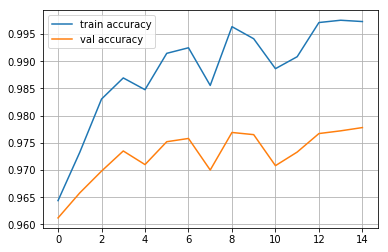

In [13]:
for epoch in range(15):

    for x_batch,y_batch in iterate_minibatches(X_train,y_train,batchsize=32,shuffle=True):
        train(network,x_batch,y_batch)
    
    train_log.append(np.mean(predict(network,X_train)==y_train))
    val_log.append(np.mean(predict(network,X_val)==y_val))
    
    clear_output()
    print("Epoch",epoch)
    print("Train accuracy:",train_log[-1])
    print("Val accuracy:",val_log[-1])
    plt.plot(train_log,label='train accuracy')
    plt.plot(val_log,label='val accuracy')
    plt.legend(loc='best')
    plt.grid()
    plt.show()
    

# DEFAULT INITIALIZATION

In [14]:
from IPython.display import clear_output
train_log = []
val_log = []

In [15]:
network = []
network.append(Dense(X_train.shape[1],200))# Layer 1
network.append(ReLU())
network.append(Dense(200, 150) )           # Layer 2
network.append(ReLU())
network.append(Dense(150,100))             # Layer 3
network.append(ReLU())
network.append(Dense(100,50))              # Layer 4
network.append(ReLU())
network.append(Dense(50,10))               # Layer 5

Epoch 14
Train accuracy: 0.11356
Val accuracy: 0.1064


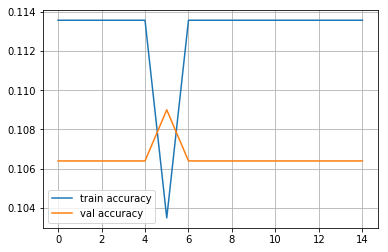

In [16]:
for epoch in range(15):

    for x_batch,y_batch in iterate_minibatches(X_train,y_train,batchsize=32,shuffle=True):
        train(network,x_batch,y_batch)
    
    train_log.append(np.mean(predict(network,X_train)==y_train))
    val_log.append(np.mean(predict(network,X_val)==y_val))
    
    clear_output()
    print("Epoch",epoch)
    print("Train accuracy:",train_log[-1])
    print("Val accuracy:",val_log[-1])
    plt.plot(train_log,label='train accuracy')
    plt.plot(val_log,label='val accuracy')
    plt.legend(loc='best')
    plt.grid()
    plt.show()

# What about smaller netwoks?

### Xavier Inicialization

In [17]:
from IPython.display import clear_output
train_log = []
val_log = []

In [18]:
network = []
network.append(Dense(X_train.shape[1],100, inicialization = 'xavier'))# Layer 1
network.append(ReLU())
network.append(Dense(100,200, inicialization = 'xavier') )            # Layer 2
network.append(ReLU())
network.append(Dense(200,10, inicialization = 'xavier'))              # Layer 3

Epoch 14
Train accuracy: 0.99986
Val accuracy: 0.9798


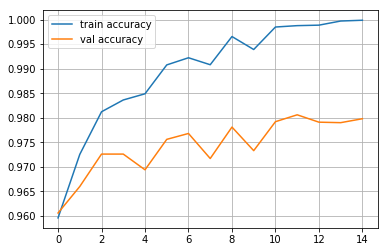

In [19]:
for epoch in range(15):

    for x_batch,y_batch in iterate_minibatches(X_train,y_train,batchsize=32,shuffle=True):
        train(network,x_batch,y_batch)
    
    train_log.append(np.mean(predict(network,X_train)==y_train))
    val_log.append(np.mean(predict(network,X_val)==y_val))
    
    clear_output()
    print("Epoch",epoch)
    print("Train accuracy:",train_log[-1])
    print("Val accuracy:",val_log[-1])
    plt.plot(train_log,label='train accuracy')
    plt.plot(val_log,label='val accuracy')
    plt.legend(loc='best')
    plt.grid()
    plt.show()

## Default initialization

In [20]:
from IPython.display import clear_output
train_log = []
val_log = []

In [21]:
network = []
network.append(Dense(X_train.shape[1],100, inicialization = 'normal'))# Layer 1
network.append(ReLU())
network.append(Dense(100,200, inicialization = 'normal') )            # Layer 2
network.append(ReLU())
network.append(Dense(200,10, inicialization = 'normal'))              # Layer 3

Epoch 14
Train accuracy: 0.99754
Val accuracy: 0.9778


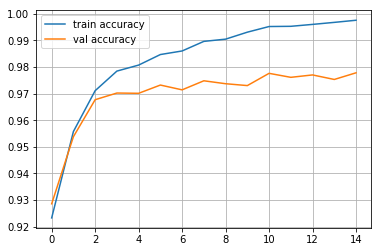

In [22]:
for epoch in range(15):

    for x_batch,y_batch in iterate_minibatches(X_train,y_train,batchsize=32,shuffle=True):
        train(network,x_batch,y_batch)
    
    train_log.append(np.mean(predict(network,X_train)==y_train))
    val_log.append(np.mean(predict(network,X_val)==y_val))
    
    clear_output()
    print("Epoch",epoch)
    print("Train accuracy:",train_log[-1])
    print("Val accuracy:",val_log[-1])
    plt.plot(train_log,label='train accuracy')
    plt.plot(val_log,label='val accuracy')
    plt.legend(loc='best')
    plt.grid()
    plt.show()

Here, we have run 2 experiments. In the first, we tested both xavier and normal initialization in a  neural network with 5 layers, in the second experiment a smaller network was trained in the same conditions. 

From the val and train plots, we can see that having a values initialization that allows keeping the weights near the same range through all the layers also allows us to update them successfully. This is more clear when we are going to deeper networks. 

# Time to sanity tests

In [23]:
l = Dense(128, 150)

"""
assert -0.05 < l.weights.mean() < 0.05 and 1e-3 < l.weights.std() < 1e-1,\
    "The initial weights must have zero mean and small variance. "\
    "If you know what you're doing, remove this assertion."
"""
assert -0.05 < l.biases.mean() < 0.05, "Biases must be zero mean. Ignore if you have a reason to do otherwise."

# To test the outputs, we explicitly set weights with fixed values. DO NOT DO THAT IN ACTUAL NETWORK!
l = Dense(3,4)

x = np.linspace(-1,1,2*3).reshape([2,3])
l.weights = np.linspace(-1,1,3*4).reshape([3,4])
l.biases = np.linspace(-1,1,4)

assert np.allclose(l.forward(x),np.array([[ 0.07272727,  0.41212121,  0.75151515,  1.09090909],
                                          [-0.90909091,  0.08484848,  1.07878788,  2.07272727]]))
print("Well done!")

Well done!


In [24]:
# To test the grads, we use gradients obtained via finite differences

from util import eval_numerical_gradient

x = np.linspace(-1,1,10*32).reshape([10,32])
l = Dense(32,64,learning_rate=0)

numeric_grads = eval_numerical_gradient(lambda x: l.forward(x).sum(),x)
grads = l.backward(x,np.ones([10,64]))

assert np.allclose(grads,numeric_grads,rtol=1e-3,atol=0), "input gradient does not match numeric grad"
print("Well done!")

Well done!


In [25]:
#test gradients w.r.t. params
def compute_out_given_wb(w,b):
    l = Dense(32,64,learning_rate=1)
    l.weights = np.array(w)
    l.biases = np.array(b)
    x = np.linspace(-1,1,10*32).reshape([10,32])
    return l.forward(x)
    
def compute_grad_by_params(w,b):
    l = Dense(32,64,learning_rate=1)
    l.weights = np.array(w)
    l.biases = np.array(b)
    x = np.linspace(-1,1,10*32).reshape([10,32])
    l.backward(x,np.ones([10,64]) / 10.)
    return w - l.weights, b - l.biases
    
w,b = np.random.randn(32,64), np.linspace(-1,1,64)

numeric_dw = eval_numerical_gradient(lambda w: compute_out_given_wb(w,b).mean(0).sum(),w )
numeric_db = eval_numerical_gradient(lambda b: compute_out_given_wb(w,b).mean(0).sum(),b )
grad_w,grad_b = compute_grad_by_params(w,b)

assert np.allclose(numeric_dw,grad_w,rtol=1e-3,atol=0), "weight gradient does not match numeric weight gradient"
assert np.allclose(numeric_db,grad_b,rtol=1e-3,atol=0), "weight gradient does not match numeric weight gradient"
print("Well done!")

Well done!


### ReLu test

In [26]:
# some tests
from util import eval_numerical_gradient
x = np.linspace(-1,1,10*32).reshape([10,32])
l = ReLU()
grads = l.backward(x,np.ones([10,32])/(32*10))
numeric_grads = eval_numerical_gradient(lambda x: l.forward(x).mean(), x=x)
assert np.allclose(grads, numeric_grads, rtol=1e-3, atol=0),\
    "gradient returned by your layer does not match the numerically computed gradient"

### Loss function test

In [27]:
logits = np.linspace(-1,1,500).reshape([50,10])
answers = np.arange(50)%10

softmax_crossentropy_with_logits(logits,answers)
grads = grad_softmax_crossentropy_with_logits(logits,answers)
numeric_grads = eval_numerical_gradient(lambda l: softmax_crossentropy_with_logits(l,answers).mean(),logits)

assert np.allclose(numeric_grads,grads,rtol=1e-3,atol=0), "The reference implementation has just failed. Someone has just changed the rules of math."